/tmp/ipykernel_34286/96210567.py:20: RuntimeWarning: invalid value encountered in sqrt
  density = np.sqrt(pressure / polytropic_coefficient)


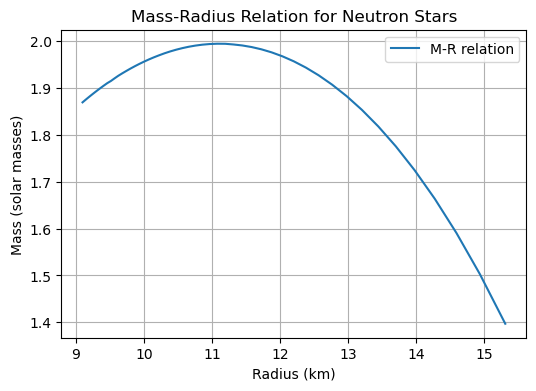

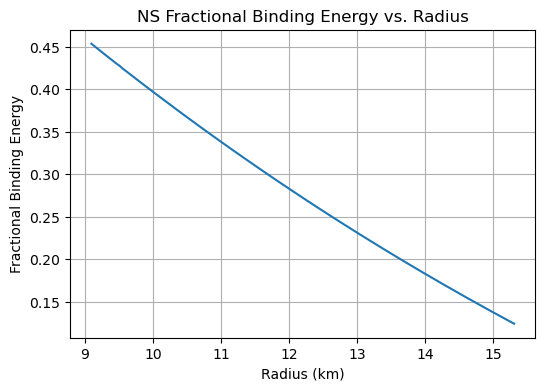

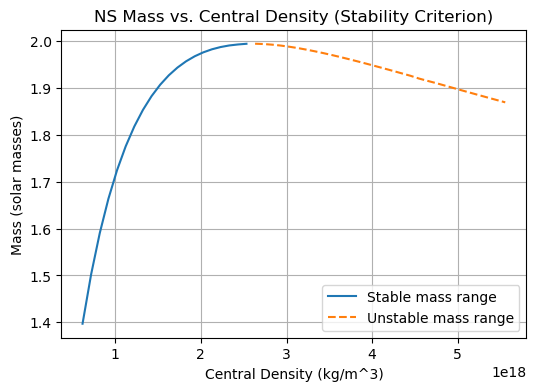

Maximum Mass for NS:  1.9947289179622747


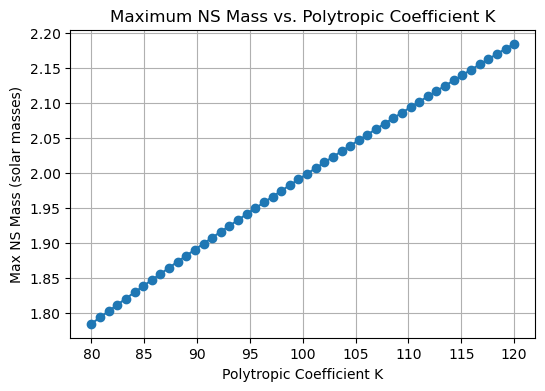

Max K:  115.0947205875922


In [5]:
# PHYS414 - Final Project
# Question 2 - Einstein
# Cem Cengiz Yazıcı
# 0076272
# cyazici20@ku.edu.tr

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.optimize import newton
from scipy.interpolate import interp1d

def tov_equations_ode(r, system, polytropic_coefficient):
    # Define the ODE system of Tolman-Oppenheimer-Volkoff (TOV) equations
    mass = system[0]
    pressure = system[2]

    # Polytropic equation of state (n = 1): P = K * rho^2 -> rho = sqrt(P / K)
    density = np.sqrt(pressure / polytropic_coefficient)

    # Derivatives
    mass_derivative = 4.0 * np.pi * r**2 * density

    if r == 0.0:
        # Avoid division-by-zero singularities at r=0
        time_dilation_derivative = 0.0
        baryonic_mass_derivative = 0.0
    else:
        time_dilation_derivative = 2.0 * (mass + 4.0 * np.pi * r**3 * pressure) / (r * (r - 2.0 * mass))
        baryonic_mass_derivative = (4.0 * np.pi* 1.0 / np.sqrt(1.0 - 2.0 * mass / r) * r**2 * density)

    pressure_derivative = -0.5 * (density + pressure) * time_dilation_derivative

    return [mass_derivative, time_dilation_derivative, pressure_derivative, baryonic_mass_derivative]

def solve_tov_equations(central_density, polytropic_coefficient):
    # Integrate TOV equation from r=0 until r=R (surface) where pressure = 0
    # Return calculated values of radius, mass and baryonic mass for given central density.
    
    mass_0 = 0.0
    time_dilation_0 = 0.0
    pressure_0 = polytropic_coefficient * (central_density**2)
    baryonic_mass_0 = 0.0

    initial_conditions = [mass_0, time_dilation_0, pressure_0, baryonic_mass_0]

    # Upper boundary on the integration radius (will stop sooner if P=0).
    max_integration_radius = 100.0

    solution = solve_ivp(tov_equations_ode, t_span=[0.0, max_integration_radius], y0=initial_conditions, args=[polytropic_coefficient])

    radius_final = solution.t[-1]
    mass_final = solution.y[0, -1]
    baryonic_mass_final = solution.y[3, -1]

    return radius_final, mass_final, baryonic_mass_final

def build_first_derivative_matrix(num_points):
    # Define 1st derivative matrix using 3-point stencil with periodic BCs.
    
    main_diag = np.zeros(num_points)
    main_diag[0] = -1.0
    main_diag[-1] = 1.0

    upper_diag = np.ones(num_points - 1)
    lower_diag = -1.0 * np.ones(num_points - 1)

    diagonals = [main_diag, upper_diag, lower_diag]
    diag_indices = [0, 1, -1]

    derivative_matrix = diags(diagonals, diag_indices).toarray()
    return derivative_matrix

def main():
    # a. Compute and plot Mass-Radius relation for varying central densities (rho) 
    # b. Calculate binding energy vs radius relation
    # c. Vary the polytropic coefficient K and find the maximum allowed mass.
    # d. Find the maximum allowed K value by root finding using the mass of biggest observed white dwarf.

    # Part a: Mass vs Radius
    central_density_array = np.linspace(1e-3, 9e-3)
    polytropic_coefficient = 100.0

    # Initialize arrays for radius, mass, and baryonic mass
    radius_array = np.zeros_like(central_density_array)
    mass_array = np.zeros_like(central_density_array)
    baryonic_mass_array = np.zeros_like(central_density_array)

    # Integrate TOV for each central density
    for i in range(len(central_density_array)):
        r_i, m_i, mb_i = solve_tov_equations(central_density_array[i], polytropic_coefficient)
        # Convert radius to kilometers (unit of ~ 1.477 km)
        radius_array[i] = r_i * 1.477
        mass_array[i] = m_i
        baryonic_mass_array[i] = mb_i

    # --- Plot (Mass vs Radius) ---
    plt.figure(figsize=(6, 4))
    plt.plot(radius_array, mass_array, label='M-R relation')
    plt.xlabel("Radius (km)")
    plt.ylabel("Mass (solar masses)")
    plt.title("Mass-Radius Relation for Neutron Stars")
    plt.legend()
    plt.grid(True)
    plt.savefig("images_einstein/e1_mass_vs_radius.png")
    plt.show()

    # Part b: Fractional Binding Energy vs Radius
    fractional_binding_energy = (baryonic_mass_array - mass_array) / mass_array

    plt.figure(figsize=(6, 4))
    plt.plot(radius_array, fractional_binding_energy, label='Fractional Binding Energy')
    plt.xlabel("Radius (km)")
    plt.ylabel("Fractional Binding Energy")
    plt.title("NS Fractional Binding Energy vs. Radius")
    plt.grid(True)
    plt.savefig("images_einstein/e2_frac_binding_energy.png")
    plt.show()

    # Part c: M vs rho_c Curve 
    # Convert central densities to SI (approximately) for the x-axis
    solar_mass_kg = 1.989e30
    geom_length_unit_m = 1477.0
    #  1 geometric density unit ~ solar_mass_kg / geom_length_unit_m^3
    central_density_array_si = (central_density_array * solar_mass_kg / (geom_length_unit_m**3))

    # Build derivative matrix to approximate dM/dρ
    # Step size in the central_density_array (geometric units)
    drho = central_density_array[1] - central_density_array[0]
    derivative_matrix = (1.0 / (2.0 * drho)) * build_first_derivative_matrix(len(central_density_array))
    mass_derivative_wrt_density = derivative_matrix @ mass_array

    # Separate stable from unstable based on sign(dM/dρ)
    mass_stable = []
    mass_unstable = []
    rho_stable = []
    rho_unstable = []

    for i in range(len(central_density_array)):
        # Stable
        if mass_derivative_wrt_density[i] >= 0.0:
            mass_stable.append(mass_array[i])
            rho_stable.append(central_density_array_si[i])
        # Unstable
        else:
            mass_unstable.append(mass_array[i])
            rho_unstable.append(central_density_array_si[i])

    # Plot stable and unstable mass range
    plt.figure(figsize=(6, 4))
    plt.plot(rho_stable, mass_stable, label="Stable mass range")
    plt.plot(rho_unstable, mass_unstable, '--', label="Unstable mass range")
    plt.xlabel("Central Density (kg/m^3)")
    plt.ylabel("Mass (solar masses)")
    plt.title("NS Mass vs. Central Density (Stability Criterion)")
    plt.legend()
    plt.grid(True)
    plt.savefig("images_einstein/e3_M_vs_rhoc.png")
    plt.show()
    print("Maximum Mass for NS: ", np.max(np.concatenate([mass_stable, mass_unstable])))

    # Part d: Maximum Allowed Mass for EOS with different polytropic coefficients K
    k_values = np.linspace(80.0, 120.0)
    central_density_array_d = np.linspace(1e-3, 9e-3)
    max_mass_for_k = np.zeros_like(k_values)

    # For each K, sweep across central densities, record maximum mass
    for i, k_val in enumerate(k_values):
        local_mass_values = []
        for cd_val in central_density_array_d:
            # We only need the mass
            _, m_val, _ = solve_tov_equations(cd_val, k_val)
            local_mass_values.append(m_val)

        max_mass_for_k[i] = np.max(local_mass_values)

    # --- Plot (Max mass vs K) ---
    plt.figure(figsize=(6, 4))
    plt.plot(k_values, max_mass_for_k, marker='o')
    plt.xlabel("Polytropic Coefficient K")
    plt.ylabel("Max NS Mass (solar masses)")
    plt.title("Maximum NS Mass vs. Polytropic Coefficient K")
    plt.grid(True)
    plt.savefig("images_einstein/e4_max_allowed_mass_eos.png")
    plt.show()
    
    # Use Root finding to calculate maximum K
    massive_neutron_star_mass = 2.14
    cubic_interp = interp1d(k_values, max_mass_for_k, kind='cubic')
    fun = lambda m: cubic_interp(m) - massive_neutron_star_mass
    max_k = newton(fun, 105)  # <-- use fun here
    print("Max K: ", max_k)

# Run the main function when this script is executed directly
if __name__ == "__main__":
    main()
